In [6]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
%matplotlib inline

from bin_time_mz import bin_time

In [7]:
import tensorflow as tf
from tensorflow.keras import *
#from tensorflow.keras import datasets, layers, models, Sequential, Input, Model, 
#from tf.keras.models import Sequential, Input, Model
#from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU

# load data

In [8]:
table = {}

for i in glob.glob("ms1_training/*"):
    
    df = pd.read_csv(i, index_col=0)
    binned = bin_time(df, rt_window=1, mz_window=1.0005079)
    table[i.replace("ms1_training/","").replace("_ms1.csv", "")] = binned
    

In [9]:
for i in glob.glob("ms1_external/*"):
    
    df = pd.read_csv(i, index_col=0)
    binned = bin_time(df, rt_window=1, mz_window=1.0005079)
    table[i.replace("ms1_external/","").replace("_ms1.csv", "")] = binned
    

In [10]:
df = pd.DataFrame(table).transpose()
df = df.apply(lambda x: x/x.max(), axis=1)
df=df.loc[:, (df != 0).any(axis=0)]
df

,99,100,101,102,103,104,105,106,107,108,...,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799
PXD016880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD007585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD016519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD002601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD009207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PXD015392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000294,0.0,0.0,0.000159,0.00072
PXD012798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD029420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000
PXD009443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000


In [11]:
del(table)

# Setup training data

In [12]:
pairs = pd.read_csv("train_pairs.txt")
pairs

,PID1,PID2,Jaccard_Index
0,PXD002434,PXD012611,0.000000
1,PXD018291,PXD014062,0.000000
2,PXD006539,PXD000050,0.000000
3,PXD018291,PXD002552,0.000000
4,PXD006539,PXD011152,0.000000
...,...,...,...
404545,PXD002087,PXD005353,0.497725
404546,PXD002212,PXD002211,0.514724
404547,PXD002081,PXD002046,0.531152
404548,PXD002081,PXD002085,0.542056


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(pairs, test_size=0.2, random_state=42)

In [14]:
train.sort_values(by=["Jaccard_Index"])

,PID1,PID2,Jaccard_Index
24597,PXD006236,PXD018300,0.000000
4874,PXD017386,PXD009683,0.000000
1450,PXD010237,PXD011085,0.000000
12451,PXD021198,PXD009595,0.000000
2536,PXD006008,PXD010944,0.000000
...,...,...,...
404542,PXD002081,PXD002082,0.448373
404543,PXD002087,PXD002046,0.452747
404544,PXD002081,PXD005353,0.457388
404546,PXD002212,PXD002211,0.514724


In [15]:
score = train['Jaccard_Index'].values
score

array([0.00465116, 0.        , 0.00389105, ..., 0.00345871, 0.0042735 ,
       0.00297619])

In [16]:
left_input = []
right_input = []

for index, row in train.iterrows():

    left_input.append( np.array(df.loc[row['PID1']]) )
    right_input.append( np.array(df.loc[row['PID2']]) )

In [17]:
len(left_input)

323640

In [18]:
left_input = np.array(left_input).reshape((len(train), len(df.columns), 1))
right_input = np.array(right_input).reshape((len(train), len(df.columns), 1))

In [19]:
np.shape(left_input)

(323640, 1700, 1)

# Second Validation Set (External)

In [20]:
test2 = pd.read_csv("test_pairs.txt")
test2

,PID1,PID2,Jaccard_Index
0,PXD005184,PXD016001,0.000000
1,PXD005184,PXD002548,0.000000
2,PXD018048,PXD017336,0.000000
3,PXD003105,PXD002548,0.000000
4,PXD016680,PXD017336,0.000000
...,...,...,...
2140,PXD007864,PXD016001,0.203302
2141,PXD015369,PXD006332,0.209389
2142,PXD009687,PXD006332,0.228904
2143,PXD029420,PXD025626,0.232863


In [21]:
test_score = test2['Jaccard_Index'].values
test_score

array([0.        , 0.        , 0.        , ..., 0.2289044 , 0.23286256,
       0.24710128])

In [22]:
test_left = []
test_right = []

for index, row in test2.iterrows():

    test_left.append( np.array(df.loc[row['PID1']]) )
    test_right.append( np.array(df.loc[row['PID2']]) )

In [23]:
test_left = np.array(test_left).reshape((len(test2), len(df.columns), 1))
test_right = np.array(test_right).reshape(((len(test2), len(df.columns), 1))

In [24]:
np.shape(test_right)

(2145, 1700, 1)

# CNN Building

In [25]:
model = tf.keras.models.Sequential([
    
    # FIRST BLOCK
    tf.keras.layers.Conv1D(32, 3, strides=1, activation='selu', padding='same',
                            kernel_initializer='glorot_uniform',
                           input_shape=(1700,1)),
    
    tf.keras.layers.Conv1D(32, 3, strides=1, activation='selu',padding='same',
                            kernel_initializer='glorot_uniform',
                          ),
    tf.keras.layers.MaxPooling1D(1, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.2),

#    SECOND BLOCK
    tf.keras.layers.Conv1D(16, 3, strides=1, activation='selu', padding='same',
                            kernel_initializer='glorot_uniform',
                            ),
    tf.keras.layers.Conv1D(16, 3, strides=1, activation='selu', padding='same',
                            kernel_initializer='glorot_uniform',
                          ),
    tf.keras.layers.MaxPooling1D(1, strides=2, padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(32, activation='selu',
                         kernel_initializer='lecun_normal',
#                        activity_regularizer=tf.keras.regularizers.l2(0.01))
#                        activity_regularizer=tf.keras.regularizers.l1(0.01)
                         activity_regularizer='l2')
 
                          
#    tf.keras.layers.Dense(1)
    
])

2023-06-19 17:53:43.038055: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 17:53:48.325375: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9653 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5
2023-06-19 17:53:48.327242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9653 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
2023-06-19 17:53:48.328990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1700, 32)          128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1700, 32)          3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 850, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 850, 32)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 850, 16)           1552      
                                                                 
 conv1d_3 (Conv1D)           (None, 850, 16)           784       
                                                        

In [27]:
# We have 2 inputs, 1 for each picture
left_in = Input((1700, 1))
right_in = Input((1700, 1))

In [28]:
# Connect each 'leg' of the network to each input
# Remember, they have the same weights
encoded_l = model(left_in)
encoded_r = model(right_in)

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1, activation='sigmoid')(L1_distance)

siamese_net = Model(inputs=[left_in,right_in],outputs=prediction)

In [29]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1700, 1)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1700, 1)]    0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           223200      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 32)           0           ['sequential[0][0]',         

In [30]:
optimization = tf.keras.optimizers.Adam(learning_rate=0.0002)

siamese_net.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=optimization,
                    metrics=['MSE'])

In [31]:
history = siamese_net.fit([left_input, right_input], score,
          batch_size=256,
          epochs=40,
          validation_data=([test_left, test_right], test_score)
               )

Epoch 1/40


2023-03-06 08:30:39.269300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-03-06 08:30:40.449378: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-03-06 08:30:40.671922: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1265/1265 [==============================] - 30s 20ms/step - loss: 0.0593 - MSE: 0.0321 - val_loss: 0.0370 - val_MSE: 0.0230
Epoch 2/40
1265/1265 [==============================] - 25s 20ms/step - loss: 0.0264 - MSE: 0.0100 - val_loss: 0.0242 - val_MSE: 0.0155
Epoch 3/40
1265/1265 [==============================] - 25s 20ms/step - loss: 0.0172 - MSE: 0.0061 - val_loss: 0.0159 - val_MSE: 0.0091
Epoch 4/40
1265/1265 [==============================] - 25s 20ms/step - loss: 0.0120 - MSE: 0.0042 - val_loss: 0.0112 - val_MSE: 0.0059
Epoch 5/40
1265/1265 [==============================] - 25s 20ms/step - loss: 0.0087 - MSE: 0.0030 - val_loss: 0.0084 - val_MSE: 0.0045
Epoch 6/40
1265/1265 [==============================] - 26s 20ms/step - loss: 0.0064 - MSE: 0.0022 - val_loss: 0.0062 - val_MSE: 0.0032
Epoch 7/40
1265/1265 [==============================] - 26s 20ms/step - loss: 0.0047 - MSE: 0.0017 - val_loss: 0.0046 - val_MSE: 0.0024
Epoch 8/40
1265/1265 [==============================] - 26s

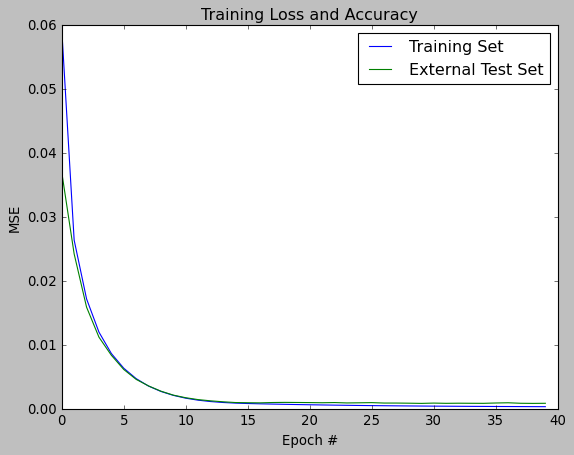

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
N = np.arange(0, 40)
plt.style.use("classic")
plt.figure(figsize=(8,6))
plt.plot(N, history.history["loss"], label="Training Set")
plt.plot(N, history.history["val_loss"], label="External Test Set")
#plt.plot(N, ext_val, label="external_validation")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show(block=True)

# External Test Set

In [33]:
predicted_external = siamese_net.predict([test_left, test_right])
predicted_external = [i[0] for i in predicted_external]

In [34]:
from scipy import stats

stats.pearsonr(test_score, predicted_external)

PearsonRResult(statistic=0.40479779955735584, pvalue=2.2354310061169208e-85)

In [35]:
test_score

array([0.        , 0.        , 0.        , ..., 0.2289044 , 0.23286256,
       0.24710128])

# Training Set

In [36]:
predicted_training = siamese_net.predict([left_input, right_input])
predicted_training = predicted_training.reshape(323640,)

In [37]:
stats.pearsonr(score, predicted_training)

PearsonRResult(statistic=0.9586437135774541, pvalue=0.0)

# Test-Split Set

In [38]:
test

,PID1,PID2,Jaccard_Index
252371,PXD017642,PXD001792,0.015518
320959,PXD010468,PXD002844,0.034405
328388,PXD019702,PXD003666,0.037709
243191,PXD012953,PXD018177,0.013959
39752,PXD013405,PXD006008,0.000378
...,...,...,...
300253,PXD004117,PXD009759,0.026976
125098,PXD006732,PXD002204,0.003120
12147,PXD021198,PXD015780,0.000000
69495,PXD010600,PXD004270,0.001086


In [39]:
internal_test = test["Jaccard_Index"]

In [40]:
test1 = []
test2 = []

for index, row in test.iterrows():

    test1.append( np.array(df.loc[row['PID1']]) )
    test2.append( np.array(df.loc[row['PID2']]) )
    

In [41]:
len(test1)

80910

In [42]:
test1 = np.array(test1).reshape((80910, 1700, 1))
test2 = np.array(test2).reshape((80910, 1700, 1))

In [43]:
predicted_testing = siamese_net.predict([test1, test2])
predicted_testing
#predicted_testing = [i[0] for i in predicted_training]

array([[0.02323242],
       [0.04396186],
       [0.04369426],
       ...,
       [0.00985842],
       [0.00866882],
       [0.01083566]], dtype=float32)

In [44]:
predicted_testing = predicted_testing.reshape(80910,)

In [45]:
stats.pearsonr(internal_test, predicted_testing)

PearsonRResult(statistic=0.9494714590677565, pvalue=0.0)

# Validation

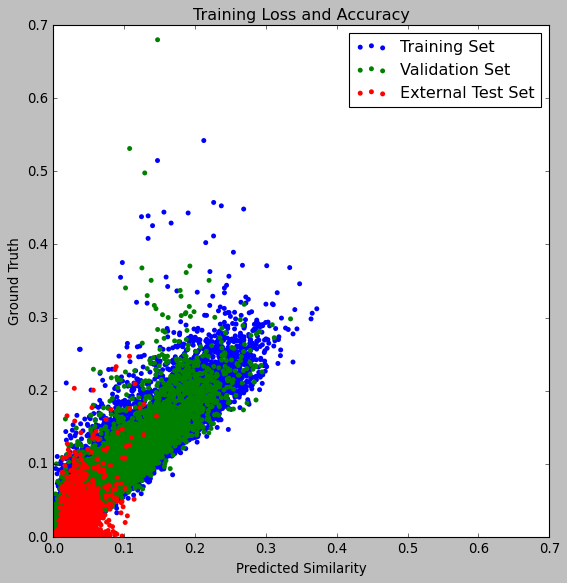

In [46]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# construct a plot that plots and displays the training history
plt.style.use("classic")
plt.figure(figsize=(8,8))
plt.scatter(predicted_training, score, label="Training Set", c='b', edgecolors="None")
plt.scatter(predicted_testing, internal_test, label="Validation Set", c='g', edgecolors="None")
plt.scatter(predicted_external, test_score, label="External Test Set", c='r', edgecolors="None")
plt.xlim(0,0.7)
plt.ylim(0,0.7)
plt.title("Training Loss and Accuracy")
plt.xlabel("Predicted Similarity")
plt.ylabel("Ground Truth")
plt.legend(loc="upper right")
plt.savefig("siamese_all.png")
plt.show(block=True)

In [47]:
all_predicted = list(predicted_training) + list(predicted_testing) + list(predicted_external)
all_truth = list(score) + list(internal_test) + list(test_score)

print("pearson", stats.pearsonr(all_predicted, all_truth))

pearson PearsonRResult(statistic=0.9549625653326231, pvalue=0.0)
